In [9]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# Wczytanie danych
df = pd.read_csv('final_dataset_undersampled_equal.csv')

In [11]:
# Konwersja kolumny Date z obsługą błędów oraz sortowanie według daty
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce', dayfirst=True)
df = df.dropna(subset=['Date'])  # Usuwamy wiersze z niepoprawnymi datami
df = df.sort_values('Date')

In [12]:
# Przygotowanie danych:
# - FTR to wynik meczu (zmienna docelowa)
# - Usuwamy kolumny, które nie są dostępne przed rozpoczęciem meczu lub mogą powodować problemy:
#   "Unnamed: 0", "FTHG", "FTAG", "MW", "HTFormPtsStr", "ATFormPtsStr", "Date"
df_model = df.drop(columns=['FTHG', 'FTAG', 'MW', 'HTFormPtsStr', 'ATFormPtsStr'])
y = df_model['FTR']
X = df_model.drop(columns=['FTR', 'Date'])

In [13]:
# Podział danych na zbiór treningowy i testowy oparty na czasie (80% najwcześniejszych, 20% najpóźniejszych)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [14]:
# Definicja cech kategorycznych i numerycznych
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [15]:
# Konwersja kolumn numerycznych do typu liczbowego (wartości niekonwertowalne stają się NaN)
for col in numerical_features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

In [16]:
# Pipeline przetwarzania danych:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [17]:
# Budowa pipeline'u: preprocessing + SVM (SVC)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=0.1,
        class_weight=None,
        degree=2,
        gamma='scale',
        kernel='linear',
        probability=True,
        random_state=42
    ))
])

In [18]:
# Trenowanie modelu
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HTGS', 'ATGS', 'HTGC',
                                                   'ATGC', 'HTP', 'ATP', 'HM1',
                                                   'HM2', 'HM3', 'HM4', 'HM5',
                                                   'AM1', 'AM2', 'AM3', 'AM4',
                                                   'AM5', 'HTFormPts',
                                                   'ATFormPts', 'HTWinStreak3',
                                                   'HTWinStreak5',
                                                   'HTLossStreak3',
                                                   'HTLossStreak5',
                                                   'ATWinStreak3',
                                                   'ATWinStreak5',
                                                   'ATLossStreak3',
                                                   'ATLossStreak5', 'HTGD',
                                                   'ATGD', 'DiffPts',
                                                   'DiffFormPts']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomeTeam', 'AwayTeam'])])),
                ('classifier',
                 SVC(C=0.1, degree=2, kernel='linear', probability=True,
                     random_state=42))])

In [19]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

In [20]:
# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu:", accuracy)
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))

Dokładność modelu: 0.4540540540540541
Raport klasyfikacji:
               precision    recall  f1-score   support

           A       0.57      0.53      0.55       198
           D       0.31      0.34      0.32       167
           H       0.48      0.48      0.48       190

    accuracy                           0.45       555
   macro avg       0.45      0.45      0.45       555
weighted avg       0.46      0.45      0.46       555



,precision,recall,f1-score,support
H,0.57,0.53,0.55,198.00
D,0.31,0.34,0.32,167.00
A,0.48,0.48,0.48,190.00
accuracy,0.45,0.45,0.45,0.45
macro avg,0.45,0.45,0.45,555.00
weighted avg,0.46,0.45,0.46,555.00


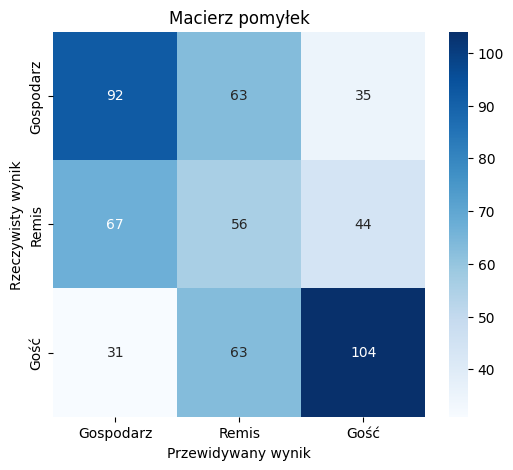

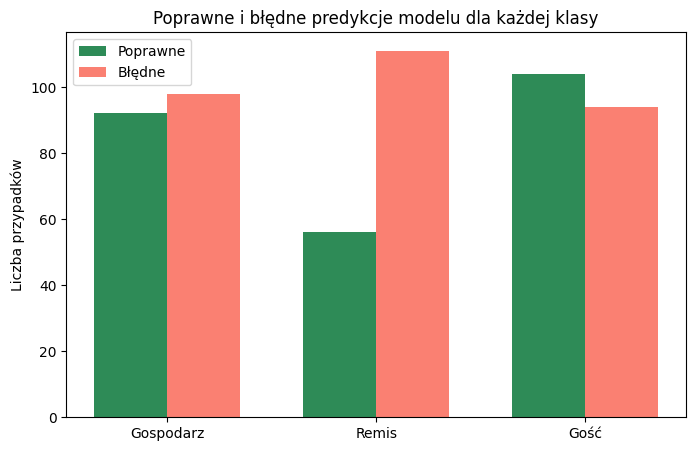

In [21]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML


# Zakładamy że masz y_true i y_pred
report = classification_report(y_test, y_pred, target_names=['H', 'D', 'A'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(2))
from IPython.display import HTML




styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())


from sklearn.metrics import confusion_matrix

# Oblicz macierz pomyłek
cm = confusion_matrix(y_test, y_pred, labels=['H', 'D', 'A'])

# Etykiety klas
labels = ['Gospodarz', 'Remis', 'Gość']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Przewidywany wynik')
plt.ylabel('Rzeczywisty wynik')
plt.title('Macierz pomyłek')
plt.show()


import numpy as np

# Tworzymy DataFrame z prawdziwymi i przewidzianymi wynikami
results_df = pd.DataFrame({'Rzeczywisty': y_test, 'Predykowany': y_pred})

# Dla każdej klasy policz trafienia i błędy
klasy = ['H', 'D', 'A']
etykiety = ['Gospodarz', 'Remis', 'Gość']
trafienia = []
pomyłki = []

for k in klasy:
    trafienia.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] == k)))
    pomyłki.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] != k)))

x = np.arange(len(klasy))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, trafienia, width, label='Poprawne', color='seagreen')
plt.bar(x + width/2, pomyłki, width, label='Błędne', color='salmon')
plt.xticks(x, etykiety)
plt.ylabel('Liczba przypadków')
plt.title('Poprawne i błędne predykcje modelu dla każdej klasy')
plt.legend()
plt.show()

In [22]:
styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())

,precision,recall,f1-score,support
H,0.57,0.53,0.55,198.00
D,0.31,0.34,0.32,167.00
A,0.48,0.48,0.48,190.00
accuracy,0.45,0.45,0.45,0.45
macro avg,0.45,0.45,0.45,555.00
weighted avg,0.46,0.45,0.46,555.00
